Dans le modèle de Kyle, nous avons 3 acteurs principaux :

1. **L'insider** : connaît la valeur de l'actif $P$ et cherche à maximiser son profit en choisissant le **volume d'ordre $V$** qu'il place sur le marché.
2. **Les noise traders** : $n$ représente leurs volumes d'ordres.
3. **Les market makers** : observent la demande totale $Y = V + n$ et fixent un prix de marché $h(Y)$ de manière à minimiser leurs pertes.

## Notations

- $P$ : Valeur de l'actif (variable aléatoire).
- $n$ : Ordres des **noise traders** (variable aléatoire).
- $V$ : Volume d'ordre de l'insider (variable à déterminer).
- $Y$ : Demande totale, on a $Y = V + n$
- $h(Y)$ : Prix de marché fixé par le market maker(variable à déterminer).
- Pour un tirage possible $\omega$, on note $P_\omega$ et $n_\omega$ les réalisations spécifiques de $P$ et $n$.

## Problème d'optimisation de l'insider

L'insider connaît la valeur de l'actif $P$ au temps $t = 0$ et veut maximiser son **profit** en fonction de son **volume d'ordre $V$**. Le prix de marché fixé par les market makers dépend de la demande totale observée, $Y = V + n$.

### Profit de l'insider

Pour un tirage $\omega$, le profit de l'insider est donné par :

$$
\text{Profit}_\text{insider} = (P_\omega - h(Y_\omega)) \cdot V
$$


### Problème de maximisation de l'insider

L'insider cherche à maximiser son profit en choisissant $V$ :

$$
\max_V \mathbb{E}\left[ (P - h(V + n)) \cdot V \right]
$$



## Problème d'optimisation des market makers

Les market makers cherchent à fixer le prix $h(Y)$ de manière à ce que leur profit espéré soit nul. Le profit d'un market maker est donné par :

### Profit des market makers
$$
\text{Profit}_\text{MM} = (h(Y) - P) \cdot Y
$$

Le market maker cherche donc à satisfaire :

$$
\mathbb{E}\left[ (h(Y) - P) \cdot Y \right] = 0
$$

**Remarque** : Dans le modèle de Kyle, les market makers sont en concurrence parfaite (compétition à la Bertrand) et sont risk-neutral. Ils fixent le prix de manière à ce que leur profit espéré soit nul, ce qui signifie qu'ils n'obtiennent aucun profit ni perte en moyenne.

# Hypothèses: 
Nous supposons que :

- $P \sim \mathcal{N}(0, \sigma_P^2)$
- $n \sim \mathcal{N}(0, \sigma_n^2)$

Nous supposons que :

- Le volume d'ordre de l'insider est lineaire en $P$ :

$$
V = \beta \cdot P + b
$$

- Le prix fixé par les market makers est lineaire en $Y$ :

$$
h(Y) = \lambda \cdot Y  + a
$$

Notre objectif est de déterminer les paramètres $\lambda$, $\beta$, $a$ et $b$ en résolvant les problèmes d'optimisation.

## Résultats théoriques

Nous obtenons les résultats théoriques suivants pour les paramètres optimaux :

  $$
  a = b = 0, \quad \beta = \frac{\sigma_n}{\sigma_P}, \quad \lambda = \frac{\sigma_P}{2\sigma_n}
  $$


In [68]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.optimize import basinhopping
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [69]:
# Paramètres
sigma_P = 1.0   # Écart-type de P (valeur de l'actif)
sigma_n = 1.0   # Écart-type de n (ordres des noise traders)
N = 10000       # Nombre de simulations

In [70]:
# Générer les données simulées pour P et n
P_samples = np.random.normal(0, sigma_P, N)
n_samples = np.random.normal(0, sigma_n, N)

# 1ere approche: 
### Problème d'Optimisation de l'Insider
$$
\text{Profit}_\text{insider} = (P - h(Y)) \cdot V
$$

L'insider cherche à résoudre :

$$
\max_V \mathbb{E}\left[ (P - h(V + n)) \cdot V \right]
$$

Pour trouver le $V$ optimal, nous calculons la dérivée du profit attendu par rapport à $V$ et l'égalons à zéro :

$$
\frac{\partial}{\partial V} \mathbb{E}\left[ (P - h(V + n)) \cdot V \right] = 0
$$
$$
\mathbb{E}\left[ \frac{\partial}{\partial V} \left( (P - h(Y)) \cdot V \right) \right] = 0
$$
En développant, on obtient la condition du premier ordre :

$$
\mathbb{E}\left[ (P - h(Y)) - V \cdot \frac{\partial h}{\partial V}(Y) \right] = 0
$$

### Problème d'Optimisation des Market Makers

Les market makers fixent le prix $h(Y)$ en fonction de la demande totale $Y$ pour que leur profit espéré soit nul, en raison de la concurrence parfaite (compétition à la Bertrand) et de leur neutralité au risque.

$$
\text{Profit}_\text{MM} = (h(Y) - P) \cdot Y
$$

Les market makers cherchent à satisfaire :

$$
\mathbb{E}\left[ (h(Y) - P) \cdot Y \right] = 0
$$

### Formulation des Conditions d'Équilibre

1. **Condition d'Optimalité de l'Insider**

$$
\mathbb{E}\left[ (P - h(Y)) - V \cdot \frac{\partial h}{\partial V}(Y) \right] = 0
$$

2. **Condition de Profit Nul des Market Makers**

$$
\mathbb{E}\left[ (h(Y) - P) \cdot Y \right] = 0
$$

### Définition de la Fonction Objectif à Minimiser

Pour résoudre ce problème numériquement, nous devons définir une fonction objectif qui combine les deux conditions d'optimalité:


$$
\text{Objective} = \left( \mathbb{E}\left[ (P - h(Y)) - V \cdot \frac{\partial h}{\partial V}(Y) \right] \right)^2 + \left( \mathbb{E}\left[ (h(Y) - P) \cdot Y \right] \right)^2
$$

Le problème revient donc à minimiser cette fonction

In [71]:
def objective(params):
    a, lambda_, beta, b = params
    
    # Calcul du volume d'ordre de l'insider pour chaque simulation
    V = beta * P_samples + b
    
    # Calcul de la demande totale observée par les market makers
    Y = V + n_samples
    
    # Calcul du prix fixé par les market makers
    h_Y = a + lambda_ * Y
    
    # Condition d'optimalité de l'insider (dérivée du profit par rapport à V)
    # dProfit/dV = P - h(Y) - lambda * V
    d_profit_dV = P_samples - h_Y - lambda_ * V
    
    insider_condition = np.mean(d_profit_dV)
    
    # Condition de profit nul des market makers
    market_maker_condition = np.mean((h_Y - P_samples) * Y)
    
    # Fonction objectif à minimiser (somme des carrés des conditions)
    objective_value = insider_condition**2 + market_maker_condition**2
    
    return objective_value


### Optimiseur local: scipy.optimize.minimize

In [72]:
# Initialisation des paramètres
initial_params = [0.0, 0.5, 0.5, 0.0]  # [a, lambda, beta, b]

# Contraintes : lambda doit être positif
bounds = [(-np.inf, np.inf), (0, np.inf), (-np.inf, np.inf), (-np.inf, np.inf)]  # [a, lambda, beta, b]

# Résolution du problème d'optimisation
result = minimize(objective, initial_params, bounds=bounds)

# Extraction des résultats optimaux
a_opt, lambda_opt, beta_opt, b_opt = result.x

print("Résultats optimaux :")
print(f"a = {a_opt}")
print(f"lambda = {lambda_opt}")
print(f"beta = {beta_opt}")
print(f"b = {b_opt}")
# Calcul de la valeur minimale de la fonction objectif
min_objective_value = objective([a_opt, lambda_opt, beta_opt, b_opt])

print(f"\nValeur minimale de la fonction objectif : {min_objective_value}")


Résultats optimaux :
a = 0.0014661817752561518
lambda = 0.4063756778220043
beta = 0.5382670630204165
b = 0.0018387615944443284

Valeur minimale de la fonction objectif : 1.674061573472143e-11


In [73]:
beta_theoretical = sigma_n / sigma_P
lambda_theoretical = sigma_P / (2 * sigma_n)
a_theoretical = 0
b_theoretical = 0

print("\nValeurs théoriques :")
print(f"a = {a_theoretical}")
print(f"lambda = {lambda_theoretical}")
print(f"beta = {beta_theoretical}")
print(f"b = {b_theoretical}")

# Calcul de la valeur de la fonction objectif pour les valeurs théoriques
min_objective_value_theoretical = objective([a_theoretical, lambda_theoretical, beta_theoretical, b_theoretical])

print(f"\nValeur de la fonction objectif pour les valeurs théoriques : {min_objective_value_theoretical}")


Valeurs théoriques :
a = 0
lambda = 0.5
beta = 1.0
b = 0

Valeur de la fonction objectif pour les valeurs théoriques : 8.845728129017492e-05


In [74]:
print("\nComparaison des résultats :")
print(f"Différence en a : {a_opt - a_theoretical}")
print(f"Différence en lambda : {lambda_opt - lambda_theoretical}")
print(f"Différence en beta : {beta_opt - beta_theoretical}")
print(f"Différence en b : {b_opt - b_theoretical}")


Comparaison des résultats :
Différence en a : 0.0014661817752561518
Différence en lambda : -0.09362432217799571
Différence en beta : -0.4617329369795835
Différence en b : 0.0018387615944443284


In [75]:
# Recalculer V et h(Y) avec les paramètres optimaux
V_opt = beta_opt * P_samples + b_opt
Y_opt = V_opt + n_samples
h_Y_opt = a_opt + lambda_opt * Y_opt

# Profits
profit_insider_opt = (P_samples - h_Y_opt) * V_opt
profit_market_makers_opt = (h_Y_opt - P_samples) * Y_opt

# Profits moyens
mean_profit_insider = np.mean(profit_insider_opt)
mean_profit_market_makers = np.mean(profit_market_makers_opt)

print("\nProfits moyens :")
print(f"Profit moyen de l'insider : {mean_profit_insider}")
print(f"Profit moyen des market makers : {mean_profit_market_makers}")


Profits moyens :
Profit moyen de l'insider : 0.4233781201010229
Profit moyen des market makers : 9.822715249406144e-07


In [76]:
mean_V = np.mean(V_opt)
mean_hY = np.mean(h_Y_opt)

print(f"\nMoyenne de V : {mean_V}")
print(f"Moyenne de h(Y) : {mean_hY}")


Moyenne de V : 0.005354550837617761
Moyenne de h(Y) : 0.004351750822130705


## Optimiseur globale scipy.optimize.differential_evolution

In [77]:
# Définir les bornes pour les paramètres
bounds = [(-10, 10), (0, 10), (0, 10), (-10, 10)]  # [a, lambda, beta, b]

# Utiliser differential_evolution pour minimiser la fonction objectif
result = differential_evolution(objective, bounds)

# Extraction des résultats optimaux
a_opt, lambda_opt, beta_opt, b_opt = result.x

print("Résultats optimaux (Differential Evolution) :")
print(f"a = {a_opt}")
print(f"lambda = {lambda_opt}")
print(f"beta = {beta_opt}")
print(f"b = {b_opt}")

# Calcul de la valeur minimale de la fonction objectif
min_objective_value_opt = objective([a_opt, lambda_opt, beta_opt, b_opt])

print(f"\nValeur minimale de la fonction objectif (paramètres optimaux) : {min_objective_value_opt}")

Résultats optimaux (Differential Evolution) :
a = -1.0637205748534884
lambda = 0.7005155255572895
beta = 0.9973821579343403
b = 0.756515630742205

Valeur minimale de la fonction objectif (paramètres optimaux) : 1.7279209267961044e-34


## Optimiseur: Basin-Hopping

In [78]:
# Initialisation des paramètres (peu importe car basin-hopping explorera)
initial_params = [0.0, 0.5, 0.5, 0.0]

# Définir les bornes comme contraintes
bounds = [(-10, 10), (0, 10), (0, 10), (-10, 10)]

# Options du minimiseur
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": bounds}

# Utiliser basin-hopping pour minimiser la fonction objectif
result = basinhopping(objective, initial_params, minimizer_kwargs=minimizer_kwargs, niter=100)

# Extraction des résultats optimaux
a_opt, lambda_opt, beta_opt, b_opt = result.x

print("\nRésultats optimaux (Basin-Hopping) :")
print(f"a = {a_opt}")
print(f"lambda = {lambda_opt}")
print(f"beta = {beta_opt}")
print(f"b = {b_opt}")

# Calcul de la valeur minimale de la fonction objectif
min_objective_value_opt = objective([a_opt, lambda_opt, beta_opt, b_opt])

print(f"\nValeur minimale de la fonction objectif (Basin-Hopping) : {min_objective_value_opt}")


Résultats optimaux (Basin-Hopping) :
a = -0.4513736888797833
lambda = 0.49469466671802287
beta = 0.5565364595661858
b = 0.4583079394489745

Valeur minimale de la fonction objectif (Basin-Hopping) : 5.763894169225393e-17


## Visualisation de la fonction objective

In [79]:
a_fixed = 0.0
b_fixed = 0.0
# Plage de valeurs pour lambda et beta
lambda_min, lambda_max = 0.1, 1.0
beta_min, beta_max = 0.1, 2.0

# Nombre de points dans chaque dimension
num_points = 50

# Création des vecteurs de valeurs
lambda_values = np.linspace(lambda_min, lambda_max, num_points)
beta_values = np.linspace(beta_min, beta_max, num_points)

# Création de la grille
Lambda_grid, Beta_grid = np.meshgrid(lambda_values, beta_values)

# Initialisation de la grille de la fonction objectif
Objective_grid = np.zeros_like(Lambda_grid)

# Boucle sur les indices de la grille
for i in range(Lambda_grid.shape[0]):
    for j in range(Lambda_grid.shape[1]):
        lambda_ij = Lambda_grid[i, j]
        beta_ij = Beta_grid[i, j]
        
        # Calcul du volume d'ordre de l'insider
        V = beta_ij * P_samples + b_fixed
        
        # Calcul de la demande totale observée par les market makers
        Y = V + n_samples
        
        # Calcul du prix fixé par les market makers
        h_Y = a_fixed + lambda_ij * Y
        
        # Condition d'optimalité de l'insider
        d_profit_dV = P_samples - h_Y - lambda_ij * V
        
        insider_condition = np.mean(d_profit_dV)
        
        # Condition de profit nul des market makers
        market_maker_condition = np.mean((h_Y - P_samples) * Y)
        
        # Fonction objectif à minimiser
        objective_value = insider_condition**2 + market_maker_condition**2
        
        # Stockage de la valeur dans la grille
        Objective_grid[i, j] = objective_value


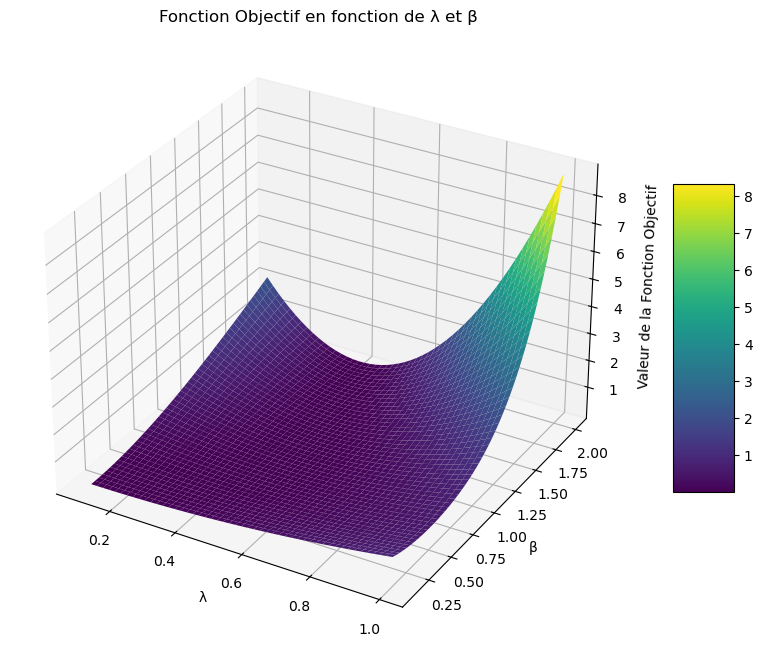

In [80]:
# Création de la figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Tracé de la surface
surf = ax.plot_surface(Lambda_grid, Beta_grid, Objective_grid, cmap='viridis', edgecolor='none')

# Ajout des étiquettes
ax.set_title("Fonction Objectif en fonction de λ et β")
ax.set_xlabel('λ')
ax.set_ylabel('β ')
ax.set_zlabel('Valeur de la Fonction Objectif')

# Ajout de la barre de couleur
fig.colorbar(surf, shrink=0.5, aspect=5)

# Affichage du graphique
plt.show()

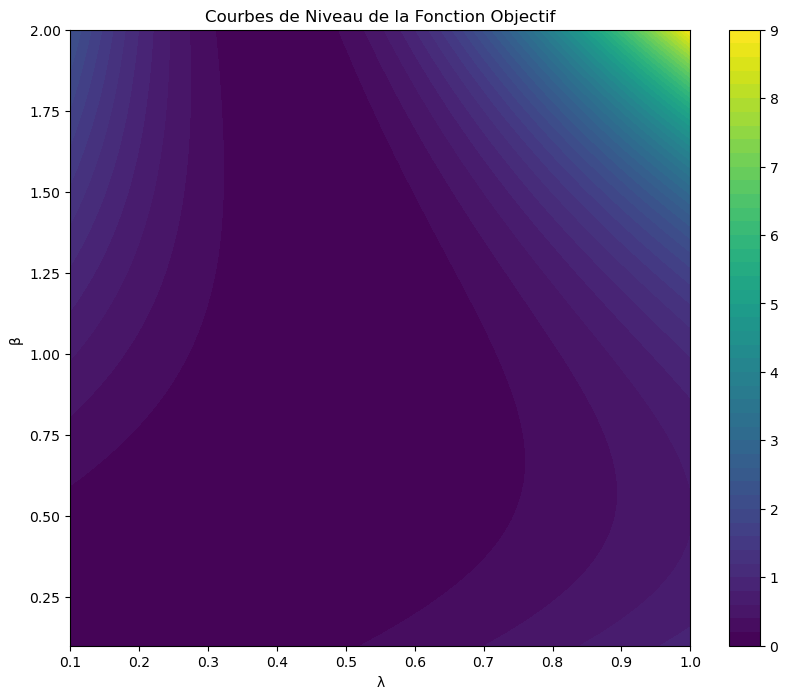

In [81]:
# Tracé des courbes de niveau
plt.figure(figsize=(10, 8))
contour = plt.contourf(Lambda_grid, Beta_grid, Objective_grid, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title("Courbes de Niveau de la Fonction Objectif")
plt.xlabel('λ')
plt.ylabel('β ')
plt.show()

In [82]:
def objective_with_regularization(params):
    a, lambda_, beta, b = params
    
    # Terme de régularisation pour pénaliser les grandes valeurs des paramètres
    regularization = 1e-20 * (a**2 + lambda_**2 + beta**2 + b**2)
    
    # Calcul de la fonction objectif avec régularisation
    return objective(params) + regularization

# Utilisation de la fonction objectif avec régularisation dans l'optimisation
result = minimize(objective_with_regularization, initial_params, bounds=bounds, options={'maxiter': 10000, 'ftol': 1e-12})

# Extraction des résultats optimaux
a_opt, lambda_opt, beta_opt, b_opt = result.x

print("Résultats optimaux avec régularisation :")
print(f"a = {a_opt}")
print(f"lambda = {lambda_opt}")
print(f"beta = {beta_opt}")
print(f"b = {b_opt}")


Résultats optimaux avec régularisation :
a = 0.0014661817752561518
lambda = 0.4063756778220043
beta = 0.5382670630204165
b = 0.0018387615944443284


## Sans l'hypothese de linéarité

Optimization successful: True
Objective function value: 0.1929022040370812
Max absolute insider condition deviation: 0.0007894763242664027
Market maker condition deviation: 4.229676899843488e-06


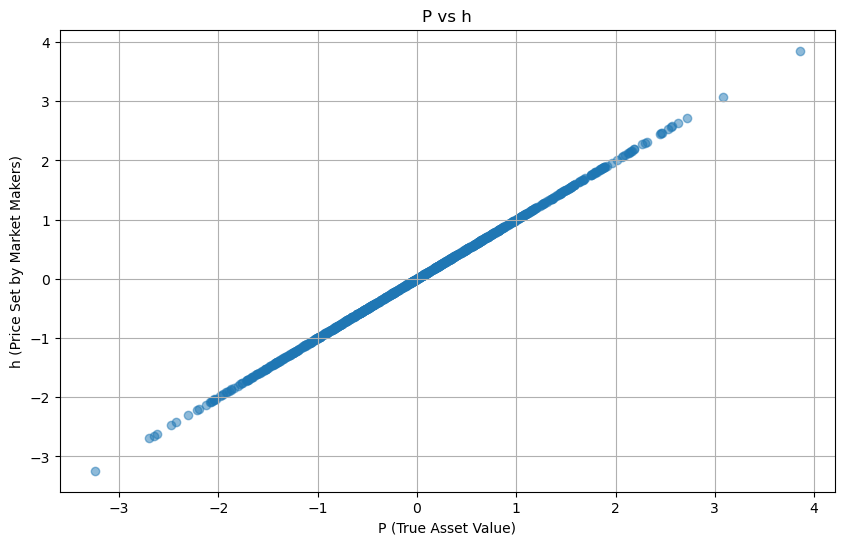

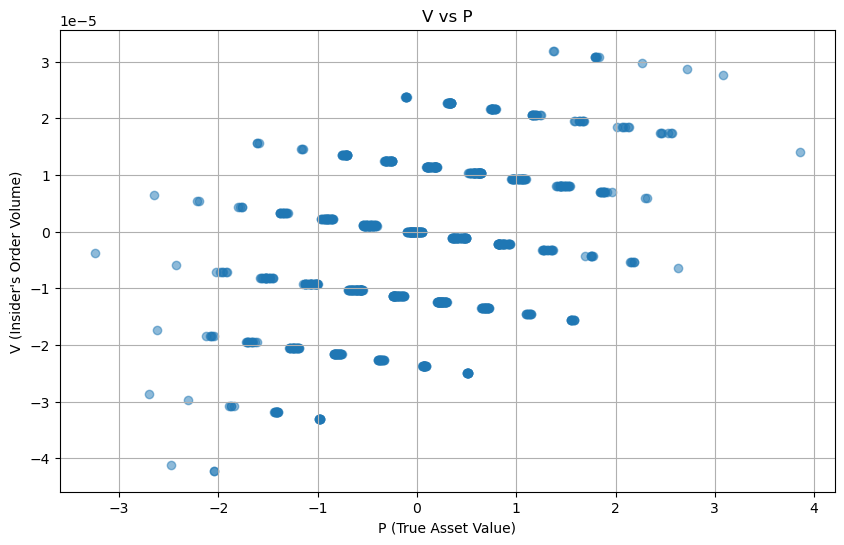

In [83]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Fix the random seed for reproducibility
np.random.seed(42)

# Parameters
sigma_P = 1.0   # Standard deviation of P (asset value)
sigma_n = 1.0   # Standard deviation of n (noise traders' orders)
N = 1000        # Number of samples (reduced to 1000 for computational feasibility)

# Generate simulated data for P and n
P_samples = np.random.normal(0, sigma_P, N)
n_samples = np.random.normal(0, sigma_n, N)

# Initial guesses for V and h
V_initial = np.zeros(N)
h_initial = np.zeros(N)

# Flatten V and h into a single vector
theta_initial = np.concatenate([V_initial, h_initial])

# Define the objective function
def objective(theta):
    # Split theta back into V and h
    V = theta[:N]
    h = theta[N:]
    
    # Compute Y
    Y = V + n_samples
    
    # Insider's profit derivative w.r.t V (vector)
    d_profit_dV = P_samples - h - V * 0  # Since h does not depend on V directly
    
    # Insider's condition: derivative should be zero
    insider_condition = d_profit_dV
    
    # Market makers' zero-profit condition
    market_maker_condition = np.mean((h - P_samples) * Y)
    
    # Compute the objective function
    objective_value = np.sum(insider_condition**2) + market_maker_condition**2
    
    # Optional: Add regularization terms
    # Regularization to promote smoothness in V and h
    regularization = 1e-4 * (np.sum(np.diff(V)**2) + np.sum(np.diff(h)**2))
    
    objective_value += regularization
    
    return objective_value

# Use L-BFGS-B optimizer
result = minimize(objective, theta_initial, method='L-BFGS-B', options={'maxiter': 500})

# Extract optimized V and h
theta_opt = result.x
V_opt = theta_opt[:N]
h_opt = theta_opt[N:]

# Print the result status
print("Optimization successful:", result.success)
print("Objective function value:", result.fun)

# Verify the conditions
# Insider's condition
d_profit_dV_opt = P_samples - h_opt

max_insider_condition = np.max(np.abs(d_profit_dV_opt))
print("Max absolute insider condition deviation:", max_insider_condition)

# Market makers' condition
Y_opt = V_opt + n_samples
market_maker_condition_opt = np.mean((h_opt - P_samples) * Y_opt)
print("Market maker condition deviation:", market_maker_condition_opt)

# Plot P vs h
plt.figure(figsize=(10, 6))
plt.scatter(P_samples, h_opt, alpha=0.5)
plt.xlabel('P (True Asset Value)')
plt.ylabel('h (Price Set by Market Makers)')
plt.title('P vs h')
plt.grid(True)
plt.show()

# Plot V vs P
plt.figure(figsize=(10, 6))
plt.scatter(P_samples, V_opt, alpha=0.5)
plt.xlabel('P (True Asset Value)')
plt.ylabel('V (Insider\'s Order Volume)')
plt.title('V vs P')
plt.grid(True)
plt.show()


# 2eme approche: 

L'objectif est de montrer que résoudre ces conditions équivaut exactement à résoudre les problèmes d'optimisation théoriques suivants :

### Problème de maximisation de l'insider :

$$
\max_V \mathbb{E}\left[ (P - h(V + n)) \cdot V \right]
$$

### Problème de minimisation des market makers : 
$$
\mathbb{E}\left[ (h(Y) - P) \cdot Y \right] = 0
$$

$$
\min_h \mathbb{E}\left[ (h(V + n) - P)^2 \right]
$$

## Approche Appropriée : Cadre Théorique des Jeux

Pour modéliser correctement ce scénario, il est nécessaire d'utiliser un cadre théorique des jeux, en résolvant spécifiquement un **équilibre de Nash** où chaque agent optimise son propre objectif tout en prenant en compte la stratégie de l'autre agent.

Dans le modèle de Kyle, l'insider et le market maker participent à un jeu stratégique :

- L'insider choisit une stratégie de trading $V(P)$ pour maximiser son profit espéré, étant donné la règle de tarification $h(Y)$ du market maker.
- Le market maker fixe une règle de tarification $h(Y)$ pour minimiser son erreur de tarification attendue (ou pour garantir un profit nul), en fonction de la stratégie de trading $V(P)$ de l'insider.

### Approche de Solution

### 1. Méthode des Réponses Optimales Itératives

Une méthode pour trouver l'équilibre de Nash consiste à utiliser une **approche itérative de réponse optimale** :

- **Étape 1** : Fixer la règle de tarification du market maker $h(Y)$, puis résoudre le problème de maximisation de l'insider pour trouver le $V(P)$ optimal.
- **Étape 2** : Étant donné la stratégie de l'insider $V(P)$, résoudre le problème de minimisation du market maker pour trouver le $h(Y)$ optimal.
- **Étape 3** : Répéter les étapes 1 et 2 jusqu'à convergence (c'est-à-dire jusqu'à ce que $V(P)$ et $h(Y)$ ne changent plus significativement).

### 2. Optimisation Simultanée en Utilisant les Conditions d'Équilibre

Une autre approche consiste à formuler le problème comme un système d'équations dérivées des **conditions du premier ordre (FOC)** des deux agents :

- **FOC de l'insider** : La dérivée du profit espéré de l'insider par rapport à $V(P)$ est égale à zéro.
- **FOC du market maker** : La dérivée de l'erreur quadratique moyenne du market maker par rapport à $h(Y)$ est égale à zéro.

Ces conditions peuvent être combinées dans un seul système et résolues simultanément.

### Mise en Œuvre de la Méthode des Réponses Optimales Itératives en Python

Nous allons implémenter la méthode des réponses optimales itératives étape par étape.

#### Initialisation

Commencez avec une première estimation pour la règle de tarification du market maker $h^{(0)}(Y)$. On peut supposer une règle de tarification linéaire : $h(Y) = a + \lambda Y$.

#### Étape 1 : Problème de l'Insider

Pour un $h(Y)$ donné, l'insider résout :

$$
\max_{V(P)} \mathbb{E}\left[ (P - h(V(P) + n)) \cdot V(P) \right]
$$

Étant donné $h(Y)$, le problème de l'insider peut être résolu analytiquement si l'on suppose des stratégies linéaires.

#### Étape 2 : Problème du Market Maker

Étant donné $V(P)$, le market maker résout :

$$
\min_{h(Y)} \mathbb{E}\left[ (h(Y) - P)^2 \right]
$$

Encore une fois, avec des stratégies linéaires, ce problème peut être résolu analytiquement.

### Processus Itératif

- **Itération $k$** :
  - **Étape 1** : Pour un $h^{(k)}(Y)$ donné, calculez le $V^{(k)}(P)$ optimal.
  - **Étape 2** : Pour un $V^{(k)}(P)$ donné, calculez le $h^{(k+1)}(Y)$ optimal.
  - Répétez jusqu'à convergence.

### Mise en Œuvre des Stratégies Linéaires

Supposons des formes linéaires pour $V(P)$ et $h(Y)$ :

- **Stratégie de l'insider** : $V(P) = \beta P + b$
- **Règle de tarification du market maker** : $h(Y) = a + \lambda Y$

#### Résolution du Problème de l'Insider étant Donné $h(Y)$

Étant donné $h(Y) = a + \lambda Y$, le profit espéré de l'insider est :

$$
\mathbb{E}\left[ (P - (a + \lambda Y)) \cdot V(P) \right]
$$

En substituant $Y = V(P) + n$ et $V(P) = \beta P + b$, et en prenant les espérances, nous pouvons dériver les $\beta$ et $b$ optimaux en fonction de $\lambda$ et $a$.

#### Résolution du Problème du Market Maker étant Donné $V(P)$

Étant donné $V(P) = \beta P + b$, le market maker minimise :

$$
\mathbb{E}\left[ (a + \lambda Y - P)^2 \right]
$$

Encore une fois, en substituant $Y = V(P) + n$, nous pouvons dériver les $\lambda$ et $a$ optimaux en fonction de $\beta$ et $b$.


Iteration 1: difference = 0.6666666666666666
Iteration 2: difference = 0.0662918456043573
Iteration 3: difference = 0.02521285806723017
Iteration 4: difference = 0.009836481665897567
Iteration 5: difference = 0.003800329903069888
Iteration 6: difference = 0.001473841875016868
Iteration 7: difference = 0.0005707462271387076
Iteration 8: difference = 0.00022114764157354916
Iteration 9: difference = 8.566942810828149e-05
Iteration 10: difference = 3.318994286327648e-05
Iteration 11: difference = 1.2857980908997924e-05
Iteration 12: difference = 4.9813219731298375e-06
Iteration 13: difference = 1.929808854939097e-06
Iteration 14: difference = 7.476267142036974e-07

Converged after 14 iterations
Insider's optimal beta: 0.6184888224035817
Insider's optimal b: 0.0013210818382115596
Market maker's optimal lambda: 0.4461704561355315
Market maker's optimal a: -0.008174477997749442

Theoretical beta: 1.0
Theoretical lambda: 0.5


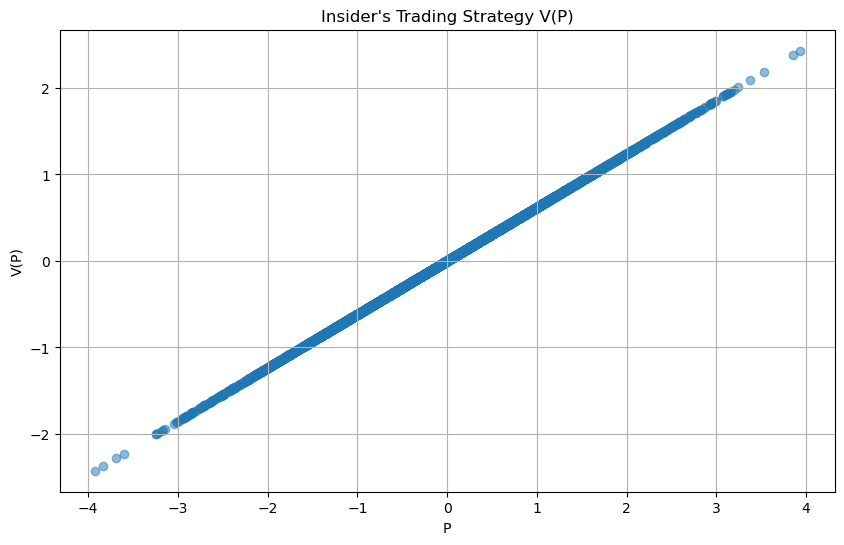

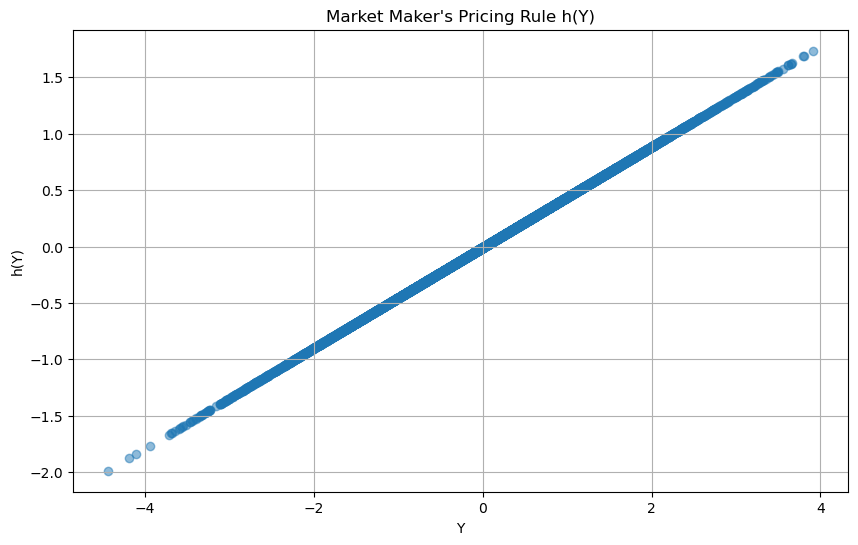

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Fix random seed for reproducibility
np.random.seed(42)

# Parameters
sigma_P = 1.0
sigma_n = 1.0
N = 10000

# Generate samples
P_samples = np.random.normal(0, sigma_P, N)
n_samples = np.random.normal(0, sigma_n, N)

# Initial guess for market maker's parameters
a_mm = 0.0
lambda_mm = 0.5

# Initialize insider's parameters
beta_in = 0.0
b_in = 0.0

# Convergence criteria
tolerance = 1e-6
max_iterations = 100
difference = np.inf
iteration = 0

while difference > tolerance and iteration < max_iterations:
    # Store old parameters for convergence check
    beta_in_old = beta_in
    b_in_old = b_in
    a_mm_old = a_mm
    lambda_mm_old = lambda_mm

    # Step 1: Insider's Problem
    # Given a_mm and lambda_mm, find beta_in and b_in

    # The insider's problem can be solved by taking derivative of expected profit w.r.t beta and b

    # Calculate expectations
    # E[P^2], E[P], E[n], E[n^2], E[P*n]
    E_P2 = np.mean(P_samples**2)
    E_P = np.mean(P_samples)
    E_n = np.mean(n_samples)
    E_n2 = np.mean(n_samples**2)
    E_Pn = np.mean(P_samples * n_samples)

    # Insider's optimal beta and b
    denom = (1 + lambda_mm * (beta_in_old**2 * sigma_P**2 + sigma_n**2))
    beta_in = (sigma_P**2) / denom
    b_in = -beta_in * E_P

    # Step 2: Market Maker's Problem
    # Given beta_in and b_in, find a_mm and lambda_mm

    # Calculate Y samples
    V_samples = beta_in * P_samples + b_in
    Y_samples = V_samples + n_samples

    # Market maker minimizes E[(a_mm + lambda_mm Y - P)^2]
    # Optimal lambda_mm and a_mm are given by linear regression of P on Y

    # Regression coefficients
    cov_Y_P = np.mean(Y_samples * P_samples) - np.mean(Y_samples) * np.mean(P_samples)
    var_Y = np.var(Y_samples)
    lambda_mm = cov_Y_P / var_Y
    a_mm = np.mean(P_samples) - lambda_mm * np.mean(Y_samples)

    # Check convergence
    difference = max(
        abs(beta_in - beta_in_old),
        abs(b_in - b_in_old),
        abs(a_mm - a_mm_old),
        abs(lambda_mm - lambda_mm_old)
    )
    iteration += 1
    print(f"Iteration {iteration}: difference = {difference}")

print("\nConverged after", iteration, "iterations")
print("Insider's optimal beta:", beta_in)
print("Insider's optimal b:", b_in)
print("Market maker's optimal lambda:", lambda_mm)
print("Market maker's optimal a:", a_mm)

# Verify that parameters are close to theoretical values
beta_theoretical = sigma_n / sigma_P
lambda_theoretical = sigma_P / (2 * sigma_n)

print("\nTheoretical beta:", beta_theoretical)
print("Theoretical lambda:", lambda_theoretical)

# Compute final strategies
V_opt = beta_in * P_samples + b_in
Y_opt = V_opt + n_samples
h_Y_opt = a_mm + lambda_mm * Y_opt

# Plot V(P)
plt.figure(figsize=(10, 6))
plt.scatter(P_samples, V_opt, alpha=0.5)
plt.xlabel('P')
plt.ylabel('V(P)')
plt.title('Insider\'s Trading Strategy V(P)')
plt.grid(True)
plt.show()

# Plot h(Y)
plt.figure(figsize=(10, 6))
plt.scatter(Y_opt, h_Y_opt, alpha=0.5)
plt.xlabel('Y')
plt.ylabel('h(Y)')
plt.title('Market Maker\'s Pricing Rule h(Y)')
plt.grid(True)
plt.show()

## 3eme approche: optimisation sous contrainte


Nous cherchons à maximiser l'espérance du profit de l'insider sous la contrainte que l'espérance du profit du market maker est nulle :

- **Fonction à maximiser (profit de l'insider)** :

  $$
  \max_V \mathbb{E}\left[ (P - h(V + n)) \cdot V \right]
  $$

- **Contrainte d'égalité** (profit du market maker) :

  $$
  \mathbb{E}\left[ (h(Y) - P) \cdot Y \right] = 0
  $$

Nous allons supposer que le problème est linéaire et que $h(Y)$ et $V(P)$ suivent des stratégies linéaires :

- **Stratégie de l'insider** : $V(P) = \beta P + b$
- **Stratégie du market maker** : $h(Y) = a + \lambda Y$

La fonction `minimize` de SciPy permet de résoudre des problèmes d'optimisation sous contrainte. Voici comment nous allons procéder :

1. **Fonction objectif** : Nous allons définir une fonction objectif que nous voulons minimiser (le négatif du profit de l'insider).
2. **Contrainte d'égalité** : Nous allons définir une contrainte d'égalité pour le market maker, à l'aide de l'argument `constraints` de `minimize`.
3. **Optimisation** : Nous allons optimiser sur les paramètres $ \lambda $, $ \beta $, $ a $, et $ b $.



In [85]:
import numpy as np
from scipy.optimize import minimize

# Fixer la graine aléatoire pour la reproductibilité
np.random.seed(42)

# Paramètres
sigma_P = 1.0   # Écart-type de P (valeur de l'actif)
sigma_n = 1.0   # Écart-type de n (ordres des noise traders)
N = 10000        # Nombre d'échantillons

# Générer les données simulées pour P et n
P_samples = np.random.normal(0, sigma_P, N)
n_samples = np.random.normal(0, sigma_n, N)

# Fonction à maximiser (on va minimiser le négatif de cette fonction)
def insider_profit(params):
    a, lambda_, beta, b = params  # Paramètres pour h(Y) et V(P)
    
    # Calculer V(P) pour chaque échantillon
    V = beta * P_samples + b
    
    # Calculer Y = V + n
    Y = V + n_samples
    
    # Calculer h(Y) pour chaque échantillon
    h_Y = a + lambda_ * Y
    
    # Profit de l'insider
    profit_insider = np.mean((P_samples - h_Y) * V)
    
    return -profit_insider  # Nous maximisons, donc nous minimisons le négatif

# Contrainte d'égalité pour le market maker (profit nul)
def market_maker_constraint(params):
    a, lambda_, beta, b = params
    
    # Calculer V(P) pour chaque échantillon
    V = beta * P_samples + b
    
    # Calculer Y = V + n
    Y = V + n_samples
    
    # Calculer h(Y) pour chaque échantillon
    h_Y = a + lambda_ * Y
    
    # Contrainte du market maker : profit espéré nul
    constraint = np.mean((h_Y - P_samples) * Y)
    
    return constraint

# Guesses initiales pour les paramètres [a, lambda, beta, b]
initial_params = [0.0, 0.5, 0.5, 0.0]

# Contrainte d'égalité pour minimize
constraints = {'type': 'eq', 'fun': market_maker_constraint}

# Résoudre le problème d'optimisation sous contrainte
result = minimize(insider_profit, initial_params, constraints=constraints, method='SLSQP')

# Extraire les paramètres optimaux
a_opt, lambda_opt, beta_opt, b_opt = result.x

# Afficher les résultats
print("Paramètres optimaux :")
print(f"a = {a_opt}")
print(f"lambda = {lambda_opt}")
print(f"beta = {beta_opt}")
print(f"b = {b_opt}")

print("\nSuccès de l'optimisation :", result.success)
print("Valeur de la fonction objectif (profit maximisé) :", -result.fun)

# Vérifier que la contrainte est bien respectée
print("Contrainte (doit être proche de 0) :", market_maker_constraint(result.x))


Paramètres optimaux :
a = 55.01633562237299
lambda = 5.110920279250248
beta = 3.525651543294104
b = -9.429327250239579

Succès de l'optimisation : False
Valeur de la fonction objectif (profit maximisé) : 4.445298479300122
Contrainte (doit être proche de 0) : 0.6220285536105697
